In [1]:
print('done')

done


In [3]:
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import keras
import numpy as np
import pandas as pd
print('Done')

Done


In [5]:
train = pd.read_csv('train.csv')
print('done')

done


In [7]:
train.head(15)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive


In [9]:
#Let's get the dataset lenght
len(train)

27481

In [11]:
#Is there any other different value than neutral, negative and positive?
train['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [13]:
#How's distributed the dataset? Is it biased?
train.groupby('sentiment').nunique()

,textID,text,selected_text
sentiment,,,
negative,7781,7781,5861
neutral,11118,11117,11111
positive,8582,8582,5537


In [15]:
#Let's keep only the columns that we're going to use
train = train[['selected_text','sentiment']]
train.head()

,selected_text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative


In [17]:
#Is there any null value?
train["selected_text"].isnull().sum()

1

In [19]:
#Let's fill the only null value.
train["selected_text"].fillna("No content", inplace = True)

In [21]:
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

In [23]:
temp = []
#Splitting pd.Series to list
data_to_list = train['selected_text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

['I`d have responded, if I were going',
 'Sooo SAD',
 'bullying me',
 'leave me alone',
 'Sons of ****,']

In [25]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['have', 'responded', 'if', 'were', 'going'], ['sooo', 'sad'], ['bullying', 'me'], ['leave', 'me', 'alone'], ['sons', 'of'], ['some', 'shameless', 'plugging', 'for', 'the', 'best', 'rangers', 'forum', 'on', 'earth'], ['fun'], ['soooo', 'high'], ['both', 'of', 'you'], ['wow', 'just', 'became', 'cooler']]


In [27]:
len(data_words)

27481

In [29]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [31]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['have responded if were going', 'sooo sad', 'bullying me', 'leave me alone', 'sons of']


In [33]:
data = np.array(data)

In [35]:
labels = np.array(train['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
y = np.array(y)
labels = to_categorical(y, num_classes=3).astype("float32")
del y

In [37]:
print(len(labels))
print(labels)

27481
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import Embedding
embedding_layer = Embedding(1000, 64)
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...   68  146   41]
 [   0    0    0 ...    0  397   65]
 [   0    0    0 ...    0    0   11]
 ...
 [   0    0    0 ...  372   10    3]
 [   0    0    0 ...   24  542    4]
 [   0    0    0 ... 2424  199  657]]


In [41]:
print(labels)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [43]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))
print(np.unique(y_train))  # Should output something like [0 1 2]

20610 6871 20610 6871
[0. 1.]


In [45]:
#model0 = Sequential()
#model0.add(layers.Embedding(max_words, 15))
#model0.add(layers.SimpleRNN(15))
#model0.add(layers.Dense(3,activation='softmax'))


#model0.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
#checkpoint0 = ModelCheckpoint("best_model0.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
#history = model0.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test),callbacks=[checkpoint0])

In [47]:
model = Sequential()
model.add(layers.Embedding(max_words, 20))
model.add(layers.LSTM(15, dropout=0.5))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy',
                             save_best_only=True, save_weights_only=False,
                             mode='auto', verbose=1)

history = model.fit(X_train, y_train,
                    epochs=70,
                    validation_data=(X_test, y_test),
                    callbacks=[checkpoint])

Epoch 1/70
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5891 - loss: 0.9052
Epoch 1: val_accuracy improved from -inf to 0.72391, saving model to best_model.keras
645/645 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.5892 - loss: 0.9050 - val_accuracy: 0.7239 - val_loss: 0.7056
Epoch 2/70
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7512 - loss: 0.6515
Epoch 2: val_accuracy improved from 0.72391 to 0.79115, saving model to best_model.keras
645/645 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.7512 - loss: 0.6514 - val_accuracy: 0.7912 - val_loss: 0.5402
Epoch 3/70
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7896 - loss: 0.5348
Epoch 3: val_accuracy improved from 0.79115 to 0.80600, saving model to best_model.keras
645/645 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.7896 - loss: 0.5347 - val_accuracy: 0.8060 - val_loss: 0.5046
Epoch 4/70
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8162 - loss: 0.4853
Epoch 4: val_accuracy did not i

In [51]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3, activation='softmax'))

model2.compile(optimizer=RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint2 = ModelCheckpoint("best_model2.keras", monitor='val_accuracy',
                             save_best_only=True, save_weights_only=False,
                             mode='auto', verbose=1)

history = model2.fit(X_train, y_train,
                    epochs=70,
                    validation_data=(X_test, y_test),
                    callbacks=[checkpoint2])

Epoch 1/70
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5695 - loss: 0.9067
Epoch 1: val_accuracy improved from -inf to 0.72522, saving model to best_model2.keras
645/645 ━━━━━━━━━━━━━━━━━━━━ 33s 49ms/step - accuracy: 0.5696 - loss: 0.9065 - val_accuracy: 0.7252 - val_loss: 0.6592
Epoch 2/70
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7509 - loss: 0.6213
Epoch 2: val_accuracy improved from 0.72522 to 0.78402, saving model to best_model2.keras
645/645 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step - accuracy: 0.7509 - loss: 0.6212 - val_accuracy: 0.7840 - val_loss: 0.5530
Epoch 3/70
644/645 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7909 - loss: 0.5342
Epoch 3: val_accuracy improved from 0.78402 to 0.79159, saving model to best_model2.keras
645/645 ━━━━━━━━━━━━━━━━━━━━ 31s 48ms/step - accuracy: 0.7910 - loss: 0.5341 - val_accuracy: 0.7916 - val_loss: 0.5054
Epoch 4/70
645/645 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8173 - loss: 0.4780
Epoch 4: val_accuracy improv

In [ ]:
from keras import regularizers
model3 = Sequential()
model3.add(layers.Embedding(max_words, 40, input_length=max_len))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(3,activation='softmax'))
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])

model3.compile(optimizer=RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint3 = ModelCheckpoint("best_model3.keras", monitor='val_accuracy',
                             save_best_only=True, save_weights_only=False,
                             mode='auto', verbose=1)

history = model3.fit(X_train, y_train,
                    epochs=70,
                    validation_data=(X_test, y_test),
                    callbacks=[checkpoint3])

In [ ]:
model4 = keras.models.Sequential()
model4.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1],1)))
model4.add(keras.layers.LSTM(64, return_sequences=False))
model4.add(keras.layers.Dense(128, activation="relu"))
model4.add(keras.layers.Dropout(0.5))
model4.add(keras.layers.Dense(1))

model4.compile(optimizer="adam",
              loss="mae",
              metrics=['accuracy'])

checkpoint4 = ModelCheckpoint("best_model4.keras", monitor='val_accuracy',
                             save_best_only=True, save_weights_only=False,
                             mode='auto', verbose=1)

training = model.fit(X_train, y_train, epochs=15, batch_size=32,callbacks=[checkpoint4])

In [ ]:
#Let's load the best model obtained during training
best_model = keras.models.load_model("best_model2.keras")

In [59]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

215/215 - 2s - 11ms/step - accuracy: 0.8411 - loss: 0.4343
Model accuracy:  0.8410711884498596


In [61]:
predictions = best_model.predict(X_test)

215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


In [63]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

<Axes: >

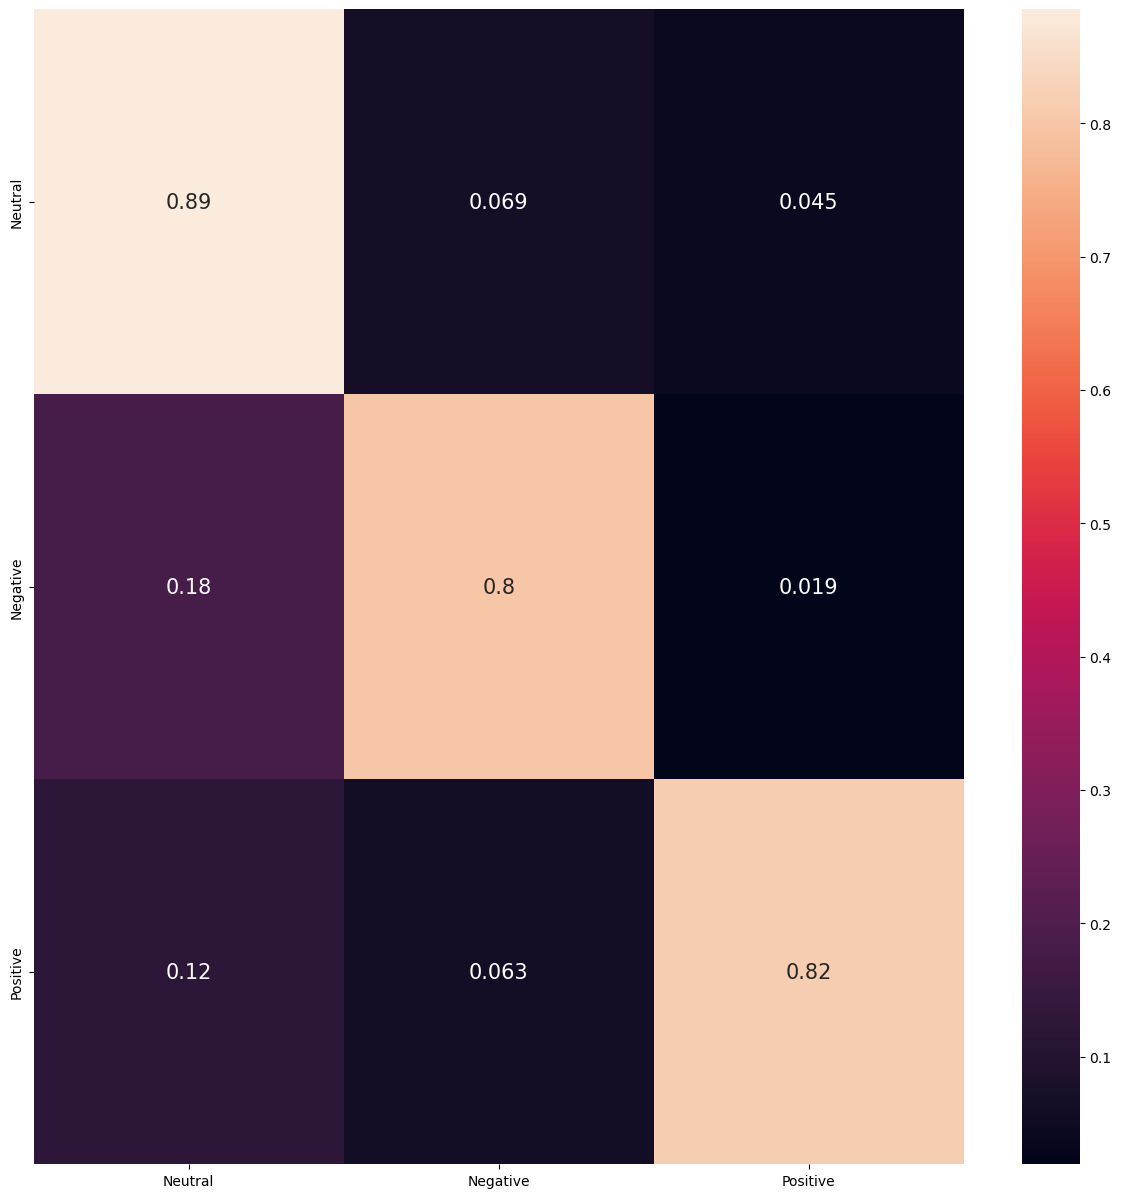

In [69]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float').div(conf_matrix.sum(axis=1), axis=0)
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

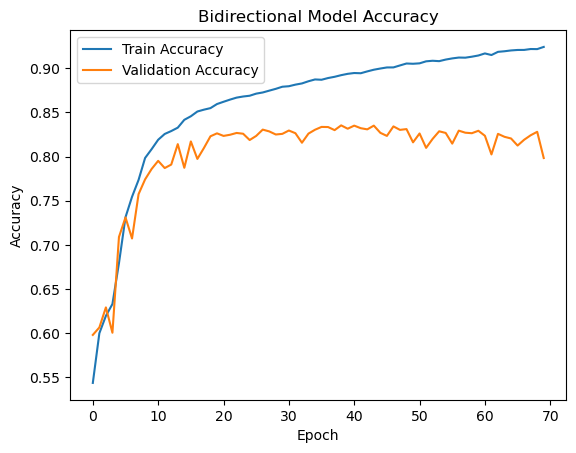

In [73]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Bidirectional Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()